In [1]:
%cd C:\Users\yukir\Documents\GitHub\Sign_Recognition\py

from basic_preprocessing import *
from deeplearning_check import *
from machine_learning import *

gpu_check()
set_global_determinism(seed=SEED)

import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import glob
import math
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import Image

import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import keras

#cv
import cv2
import math
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils
import xml.etree.ElementTree as ET

import random 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.image as mpimg
from matplotlib import font_manager, rc
rc('font',family="consolas")
plt.rcParams["font.family"]="consolas" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="consolas", 
        rc={"axes.unicode_minus":False},style='darkgrid')

%cd C:\Users\yukir\Documents\Monicas_workspace\Knee

C:\Users\yukir\Documents\GitHub\Sign_Recognition\py


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13377317746360234826
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5970866416093687780
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1746271159224370479
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10208904762537680182
physical_device_desc: "device: XLA_GPU device"
]
tf 2.2.0
keras 2.3.0-tf
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
C:\Users\yukir\Documents\Monicas_workspace\Knee


In [2]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()
    fig = plt.gcf()
    fig.savefig("../03_model_visualization/"+model_name+".jpg")
    plt.close(fig)

#### DATA

In [28]:
train_dir = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Knee\\vgg_dataset\\org_preproc\\train'
test_dir = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Knee\\vgg_dataset\\org_preproc\\test'
val_dir = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Knee\\vgg_dataset\\org_preproc\\val'

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(224,224), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(224, 224), color_mode='rgb')

input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

Found 6262 images belonging to 5 classes.
Found 1935 images belonging to 5 classes.
Found 1543 images belonging to 5 classes.


In [38]:
from tensorflow.keras.applications import VGG16

def create_model():
    optimizer = Adam()
    
    pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    #include_top FC 레이어 포함유무 결정
    #feature extraction 파라미터들은 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에 trainable의 속성을 False
    pre_trained_vgg.trainable = False
    additional_model = tf.keras.Sequential()
    additional_model.add(pre_trained_vgg)
    additional_model.add(Flatten())
    additional_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(2048, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(1024, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(5, activation='softmax'))
    

    additional_model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics=['acc'])

    
    return additional_model

In [39]:
# 모델 실행 옵션 
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 5125      
Total params: 127,973,189
Trainable params: 113,258,501
Non-trainable params: 14,714,688
_______________________________

In [40]:
checkpoint_path = "check_point/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [41]:
#모델의 가중치 저장
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
            monitor='loss', 
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)

#새로운 콜백으로 모델 훈련하기
history = model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=100, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint],
            shuffle=False)

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 1.5047 - acc: 0.4377
Epoch 00001: loss improved from inf to 1.50471, saving model to check_point/cp.ckpt
392/392 [==============================] - 81s 208ms/step - loss: 1.5047 - acc: 0.4377 - val_loss: 1.3644 - val_acc: 0.4548
Epoch 2/100
391/392 [============================>.] - ETA: 0s - loss: 1.1022 - acc: 0.5257  ETA: 20s - loss: 1.1122 - acc - ETA: 19s - loss: 1.11 - E - ETA: 17s - loss: 1.1108 - ETA: 14s - loss: 1.1038 - acc:  - ETA: 14s  - ETA - ETA: 9s - loss: 1.1086 - acc: 0 - ETA: 8s - loss:  - ETA: 6s - loss: 1.1085 - ac - ETA: 6s - loss: 1.1066 -  - ETA: 5s - loss: 1.1080 - - ETA: 3s - loss: 1.1 - ETA: 2s - loss
Epoch 00002: loss improved from 1.50471 to 1.10184, saving model to check_point/cp.ckpt
392/392 [==============================] - 54s 138ms/step - loss: 1.1018 - acc: 0.5259 - val_loss: 1.1286 - val_acc: 0.5344
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 1.0396 - ac

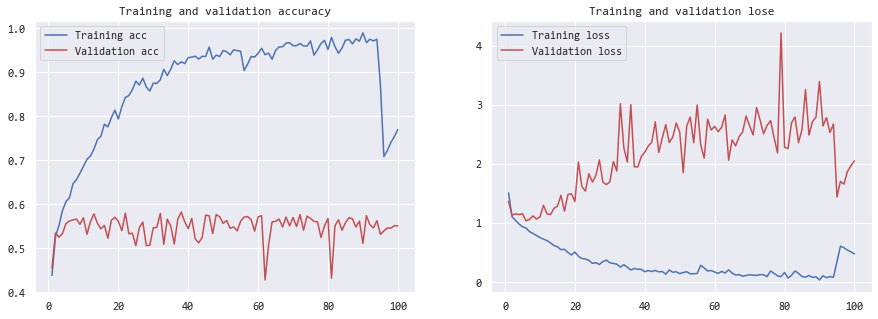

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()